In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

- Simulate the trajectory of a ball with the parameters launch position (especially the height
above an imaginary ground), launch speed and launch angle of the ball.
- Simulate the observation of the ball position (x, y as shown in the slides). The estimated
ball position shall be subject to uncertainty and it shall be possible to parameterize this
uncertainty. In addition, the time span between two observations shall be variable and the
observations shall be able to drop out completely over a certain period of time.
- The initial parameters of the Kalman Filter shall be adaptable.
- The normally distributed noise on transition and observation should be adjustable. This means
that the covariance matrices R and Q shall be set as a parameter in the Kalman Filter.

In [2]:
def rad_deg(angle):
    return (angle*np.pi)/180

def projectile(launch_speed,angle,height,dt,total_time,g=9.81):
    theta_0 = angle
    v_0 = launch_speed
    h_0 = height
    time_sim = total_time
    step_size = dt
    samples = int(time_sim/step_size)
    time = np.linspace(0,time_sim,samples)
    vx_0 = np.cos(rad_deg(theta_0))*v_0
    vy_0 = np.sin(rad_deg(theta_0))*v_0

    # print(time)
    x = vx_0*time
    y = vy_0*time-g*time**2*0.5+h_0
    vx = np.repeat(vx_0,samples)
    vy = vy_0-g*time
    signal = np.stack((x,y,vx,vy))
    return(signal,time)

def noise_observation(signal,mu,sd):
    noise = np.random.multivariate_normal(mu,sd,signal.shape[1]).T
    signal_n = signal + noise

    return signal_n

def hide_observations(signal,t_0,duration,dt,error_value = -999999):

    i_begin = int(t_0/dt)-1
    i_final = i_begin + int(duration/dt)+1
    # print(i_begin,i_final)
    signal_m = signal.copy()
    #print(type(signal_m))
    # signal_m[0,i_begin:i_final] = error_value
    signal_m[1,i_begin:i_final] = error_value
    return signal_m

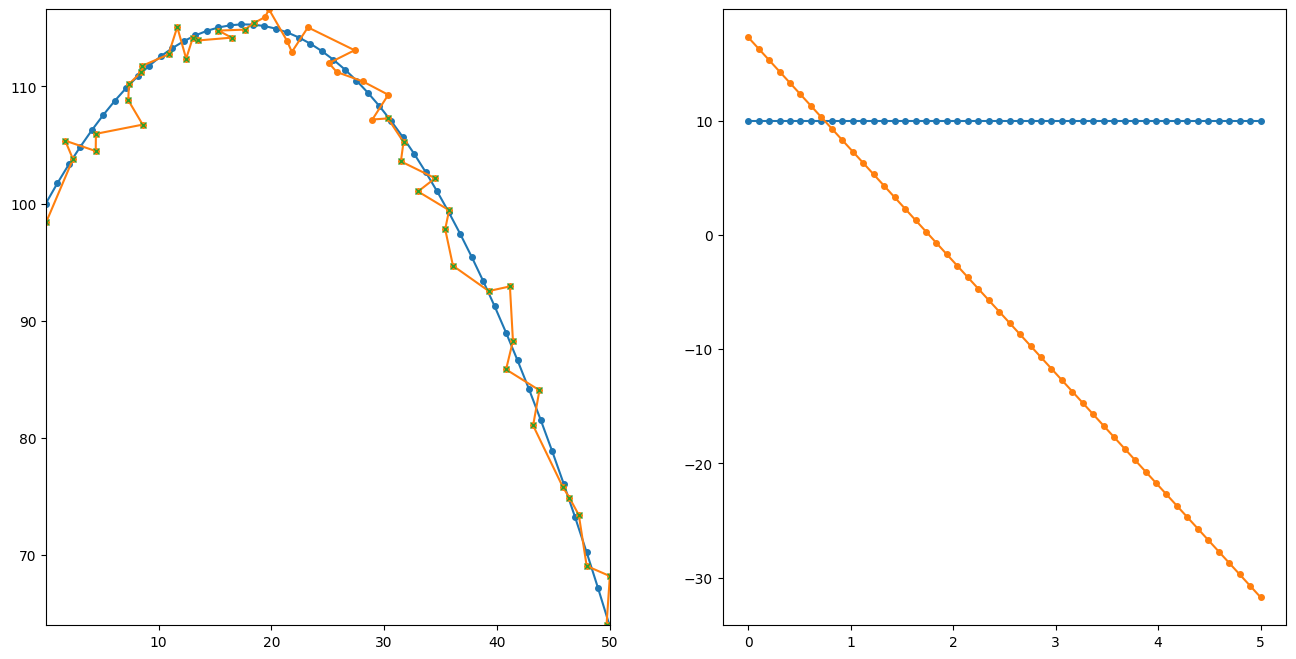

In [3]:
mu_noise = [0,0]
cov_noise = [[1,0],[0,1]]
dt = 0.1
signal_c,time = projectile(20,60,100,dt,5)
signal = signal_c[[0,1]]
signal_n = noise_observation(signal,mu_noise,cov_noise)
signal_m = hide_observations(signal_n,2,1,0.1)

fig, (ax,ax1) = plt.subplots(1,2,figsize = (16,8))
ax.plot(signal[0],signal[1],'o',ls = '-',markersize = 4)
ax.plot(signal_n[0],signal_n[1],'o',ls = '-',markersize = 4)
ax.plot(signal_m[0],signal_m[1],'x',markersize = 4)
min_y = min(signal_n[1])
min_x = min(signal_n[0])
max_y = max(signal_n[1])
max_x = max(signal_n[0])
# print(min_y,max_y)
ax.set(ylim=(min_y,max_y),xlim=(min_x,max_x))
ax1.plot(time,signal_c[2],'o',ls = '-',markersize = 4)
ax1.plot(time,signal_c[3],'o',ls = '-',markersize = 4)

In [4]:
class KalmanFilter(object):
    def __init__(self, dt, g = 9.81,initial_state = np.matrix([[0,0,0,0]]).T,Q = np.diag([1,1,1,1]),R = np.diag([1,1])):
        # Define sampling time
        self.dt = dt
        # Define the  control input variables
        self.u = np.matrix([0,g,0]).T
        # Intial State
        self.x = initial_state
        # Define the State Transition Matrix A
        self.A = np.matrix([[1, 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
        # Define the Control Input Matrix B
        self.B = np.matrix([[0,0,0],
                            [0,-0.5*self.dt**2,0],
                            [0,0,0],
                            [0,-self.dt,0]])
        # Define Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0]])
        #Initial Process Noise Covariance
        self.Q = Q
        #Initial Measurement Noise Covariance
        self.R = R
        #Initial Covariance Matrix
        self.P = np.eye(self.A.shape[1])

    def predict(self):
        # Refer to :Eq.(9) and Eq.(10)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # Update time state
        #x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        # print(f'Predict: {self.x} size: {self.x.shape}')
        return self.x[0:2]

    def update(self, z):
        # Refer to :Eq.(11), Eq.(12) and Eq.(13)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)
        #print(K)
        print(np.linalg.norm(K))
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))  #Eq.(12)
        I = np.eye(self.H.shape[1])
        # Update error covariance matrix
        self.P = (I - (K * self.H)) * self.P   #Eq.(13)
        # print(f'Update: {self.x} size: {self.x.shape}')
        return self.x[0:2]

50
1.025954545989959
0.6698248701304491
0.6369107011936658
0.6894131824044321
0.7378723847678252
0.7565770845211351
0.7461270464944629
0.715464350103621
0.6738595365659024
0.6281969414882674
0.582767845931049
0.5398952446162272
0.5006286834424516
0.46527361789565946
0.4337377655226268
0.4057390013259399
0.3809226130720656
0.35892360510528554
0.3393973014364143
error
0.3220323774226213
error
0.30655455250540853
error
0.29272559843654217
error
0.28034022465093505
error
0.2692222076451639
error
0.25922046194619
error
0.2502053824024296
error
0.24206559011077025
error
0.23470511204943836
error
0.22804097465462056
error
0.22200117006501452
error
0.21652294710169898
error
0.2115513798089018
error
0.2070381705035227
error
0.20294064961632324
error
0.1992209400597394
error
0.1958452589096591
error
0.1927833336359704
error
0.19000791391567703
error
0.18749436324834023
error
0.18522031723590215
0.18316539756701353
0.18131097253726428
0.1796399564110364
0.1781366411482485
0.17678655503028054
0.17

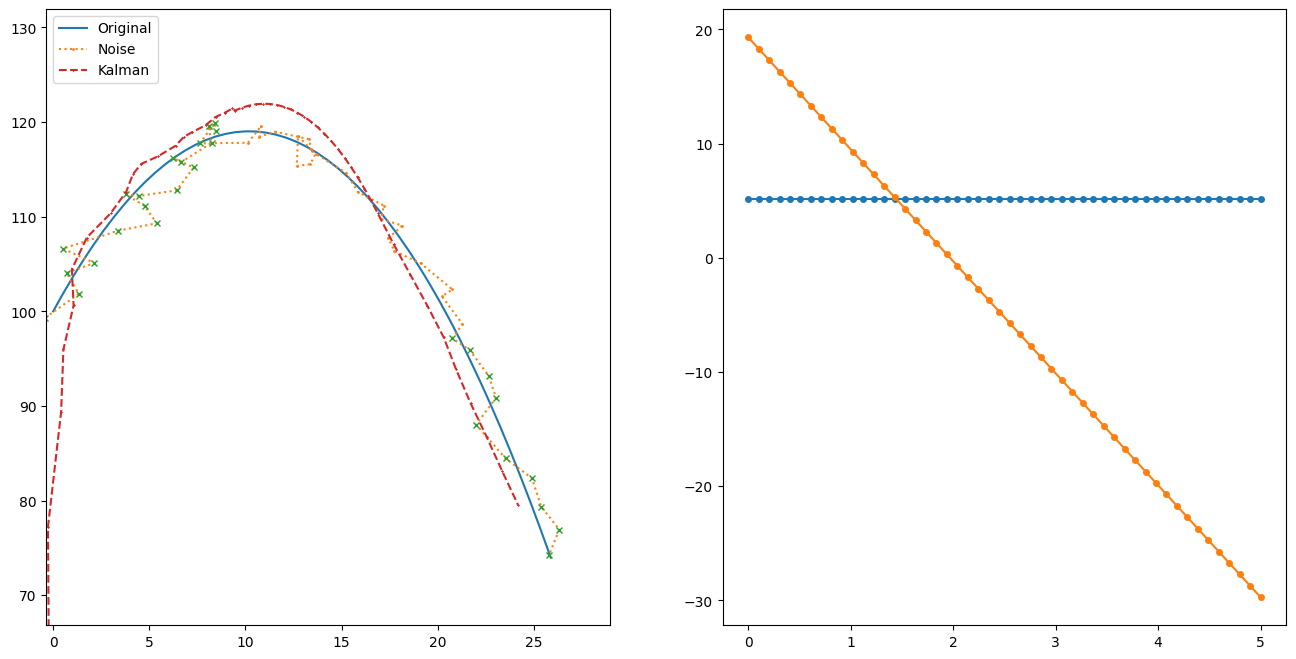

In [5]:
error_value = -999999
g = 9.81
dt = 0.1
duration = 5
height = 100
speed = 20
angle = 75
t_0_dropout = 2
duration_dropout = 2
mu_noise = [0,0]
cov_noise = [[0.5,0],[0,0.5]]
signal_c,time = projectile(speed,angle,height,dt,duration)
signal = signal_c[[0,1]]
signal_n = noise_observation(signal,mu_noise,cov_noise)
signal_m = hide_observations(signal_n,t_0_dropout,duration_dropout,dt,error_value=error_value)

x_init = np.matrix([[0],[0],[0],[0]])
Q = np.diag([0.001,0.001,0.001,0.001])
R = np.diag([0.5,0.3])
KF = KalmanFilter(dt,g,initial_state=x_init,Q=Q,R=R)

print(len(time))
x_f = []
y_f = []

for i in range(len(time)):
    # print(time[i])
    x_o = signal[0,i]
    y_o = signal[1,i]
    # print(f'real position x: {x_o} y: {y_o}')
    x_n = signal_m[0,i]
    y_n = signal_m[1,i]
    if y_n == error_value:
        print('error')
        x_n = float(x1)
        y_n = float(y1)
    # print(f'noise position x: {x_n} y: {y_n}')
    pos = np.matrix([x_n,y_n]).T
    # print(pos.shape)
    # Predict
    (x, y) = KF.predict()
    # print(f'predicted position x: {x} y: {y}')
    # Draw a rectangle as the predicted object position
    # Update
    (x1, y1) = KF.update(pos)
    #x1 = x1[0]
    #y1 = y1[0]
    #print(f'updated position x: {x1} y: {y1}')
    x_f.append(float(x))
    y_f.append(float(y))
f_pos = np.stack((x_f,y_f))

fig, (ax,ax1) = plt.subplots(1,2,figsize = (16,8))
ax.plot(signal[0],signal[1],ls = '-',markersize = 1,label = 'Original')
ax.plot(signal_n[0],signal_n[1],'o',ls=':',markersize = 1,label = 'Noise')
ax.plot(signal_m[0],signal_m[1],'x',markersize = 4)
ax.plot(f_pos[0],f_pos[1],'x',ls = '--',markersize = 1,label = 'Kalman')
ax.legend(loc = 'upper left')
min_y = min(signal_n[1])
min_x = min(signal_n[0])
max_y = max(signal_n[1])
max_x = max(signal_n[0])
print(min_y,max_y)
print(min_x,max_x)
ax.set(ylim=(min_y-min_y*0.1,max_y+0.1*max_y),xlim=(min_x-min_x*0.1,max_x+0.1*max_x))
ax1.plot(time,signal_c[2],'o',ls = '-',markersize = 4)
ax1.plot(time,signal_c[3],'o',ls = '-',markersize = 4)


### Particle Filter
- Now 2 balls are thrown and the position and velocity of both should be estimated
- The implementations should have the same parameters as the kalman filter

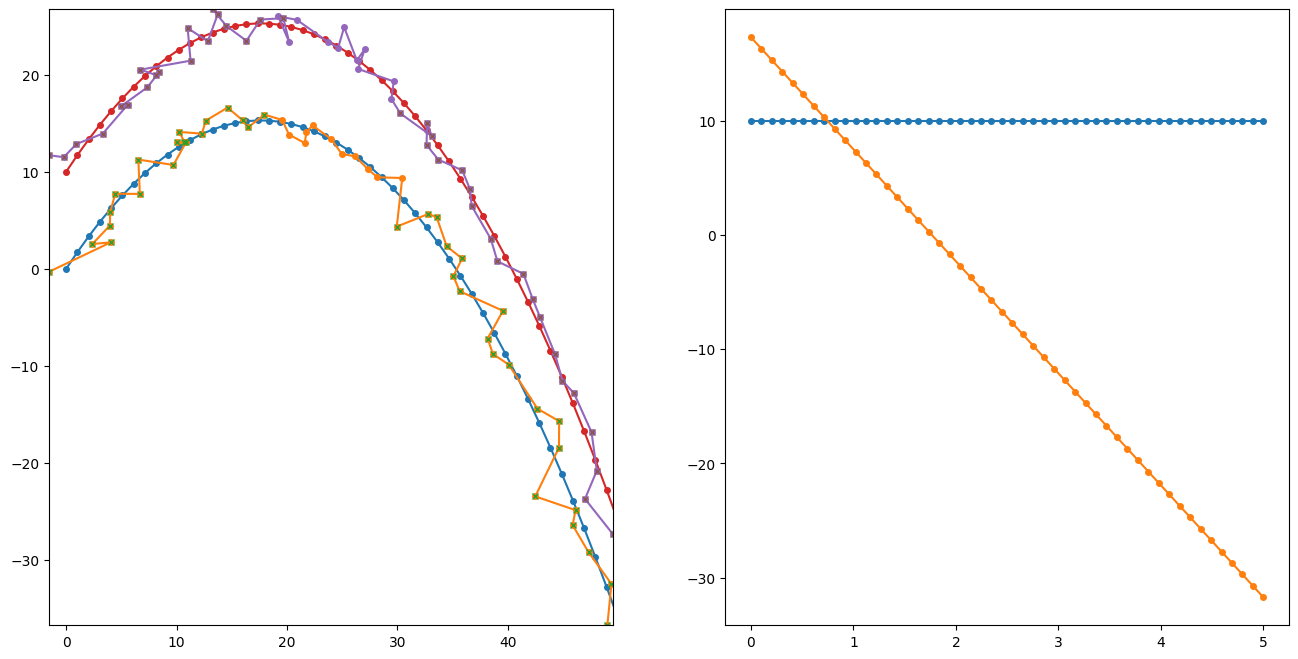

In [49]:
# Create noisy observations of 2 balls
mu_1_noise = [0,0]
cov_1_noise = [[1,0],[0,1]]

mu_2_noise = [0,0]
cov_2_noise = [[1,0],[0,1]]

dt = 0.1
signal_c_1, time = projectile(20,60,0,dt,5) # launch speed, angle, height, _, _
signal_1 = signal_c_1[[0,1]]
signal_n_1 = noise_observation(signal_1, mu_1_noise, cov_1_noise)
signal_m_1 = hide_observations(signal_n_1, 2, 1, 0.1)

signal_c_2, time = projectile(20,60,10,dt,5)
signal_2 = signal_c_2[[0,1]]
signal_n_2 = noise_observation(signal_2, mu_2_noise, cov_2_noise)
signal_m_2 = hide_observations(signal_n_2, 2, 1, 0.1)

# Combining the array of the two balls to one array
signal_c = np.array([signal_c_1, signal_c_2])
signal = signal_c[:, [0,1]]
signal_n = np.array([signal_n_1, signal_n_2])
signal_m = np.array([signal_m_1, signal_m_2])


fig, (ax,ax1) = plt.subplots(1,2,figsize = (16,8))
ax.plot(signal[0][0],signal[0][1],'o',ls = '-',markersize = 4)
ax.plot(signal_n[0][0],signal_n[0][1],'o',ls = '-',markersize = 4)
ax.plot(signal_m[0][0],signal_m[0][1],'x',markersize = 4)

ax.plot(signal[1][0],signal[1][1],'o',ls = '-',markersize = 4)
ax.plot(signal_n[1][0],signal_n[1][1],'o',ls = '-',markersize = 4)
ax.plot(signal_m[1][0],signal_m[1][1],'x',markersize = 4)

signal_n_combined_x = np.concatenate((signal_n[0][0], signal_n[1][0]))
signal_n_combined_y = np.concatenate((signal_n[0][1], signal_n[1][1]))
min_y = min(signal_n_combined_y)
min_x = min(signal_n_combined_x)
max_y = max(signal_n_combined_y)
max_x = max(signal_n_combined_x)
# print(min_y,max_y)
ax.set(ylim=(min_y,max_y),xlim=(min_x,max_x))
ax1.plot(time,signal_c[0][2],'o',ls = '-',markersize = 4)
ax1.plot(time,signal_c[0][3],'o',ls = '-',markersize = 4)

In [50]:
# Implement a Particle Filter class

import numpy as np
import scipy.stats as stats

# TODO: That's what I have already created
# motion model
def update_ball_state(ball_idx, state):
    position, velocity = state
    # Update position and velocity based on physics equations (e.g., projectile motion)
    new_position = position + velocity * delta_t
    new_velocity = velocity - gravity * delta_t
    return [new_position, new_velocity]

# TODO: That's what I have already created
# measurement model
def predict_observed_position(ball_idx, state):
    position, velocity = state
    # Add Gaussian noise to the true position to simulate shaky camera observations
    noisy_position = position + np.random.normal(loc=0, scale=observation_noise_std)
    return noisy_position




def initialize_particles(num_particles, initial_pos_1, initial_vel_1, initial_pos_2, initial_vel_2):
    particles = []
    for _ in range(num_particles):
        ball1_state = [initial_pos_1, initial_vel_1]  # Initial state of ball 1
        ball2_state = [initial_pos_2, initial_vel_2]  # Initial state of ball 2
        particles.append([ball1_state, ball2_state])
    return np.array(particles)

def calculate_likelihood(observation, predicted_observation, measurement_noise_std=1):
    # Compute the likelihood using a Gaussian distribution
    likelihood = stats.norm.pdf(observation, predicted_observation, measurement_noise_std)
    likelihood = likelihood[0] * likelihood[1] # TODO: Is this the right way to calculate a 1D likelihood from a 2D likelihood?
    return likelihood


def particle_filter(initial_particles, signal_real, signal_shaky, num_particles):
    # Initialization
    particles = initial_particles.copy()
    num_balls = 2
    weights = np.ones(num_particles) / num_particles
    estimated_states = []

    num_observations = len(signal[0][0])
    # Particle filter iterations
    for observation_idx in range(num_observations):
        if int(observation_idx+1) % 10 == 0:
          print("observation_idx:", observation_idx+1)

        # Prediction step
        for i in range(num_particles):
            for ball_idx in range(num_balls):
                new_pos = (signal_real[ball_idx][0][observation_idx], signal_real[ball_idx][1][observation_idx]) # pos_x, pos_y
                new_vel = (signal_real[ball_idx][2][observation_idx], signal_real[ball_idx][3][observation_idx]) # vel_x, vel_y
                particles[i][ball_idx] = [new_pos, new_vel]

        # Update step
        for i in range(num_particles):
            weight = 1.0
            for ball_idx in range(num_balls):
                real_pos_x = signal_real[ball_idx][0][observation_idx]
                real_pos_y = signal_real[ball_idx][1][observation_idx]
                real_pos = np.array([real_pos_x, real_pos_y])
                shaky_pos_x = signal_shaky[ball_idx][0][observation_idx]
                shaky_pos_y = signal_shaky[ball_idx][1][observation_idx]
                shaky_pos = np.array([shaky_pos_x, shaky_pos_y])

                # TODO: Do I also need velocity here?

                weight *= calculate_likelihood(real_pos, shaky_pos, measurement_noise_std=1)
            weights[i] = weight

        # Normalize weights
        weights /= np.sum(weights)

        # Resampling step
        indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles

        # Estimated state
        estimated_state = np.average(particles, weights=weights, axis=0)
        estimated_states.append(estimated_state)

    return np.array(estimated_states)

# Create initial particles
num_particles = 100
initial_pos_1 = [0,0]
initial_vel_1 = [50, 50]
initial_pos_2 = [0,10]
initial_vel_2 = [50,50]
intial_particles = initialize_particles(num_particles, initial_pos_1, initial_vel_1, initial_pos_2, initial_vel_2)

# TODO: Drop out signal by using signal_m and not signal_n here.
estimated_states = particle_filter(intial_particles, signal_c, signal_n, num_particles)

observation_idx: 10
observation_idx: 20
observation_idx: 30
observation_idx: 40
observation_idx: 50


### TODO: Understand what the shape of estimated_states is, to be able to then plot it

In [51]:
# TODO: Find out what the third index is ...

(2, 2, 50)

"\nax1.plot(time,signal_c[2],'o',ls = '-',markersize = 4)\nax1.plot(time,signal_c[3],'o',ls = '-',markersize = 4)\n"

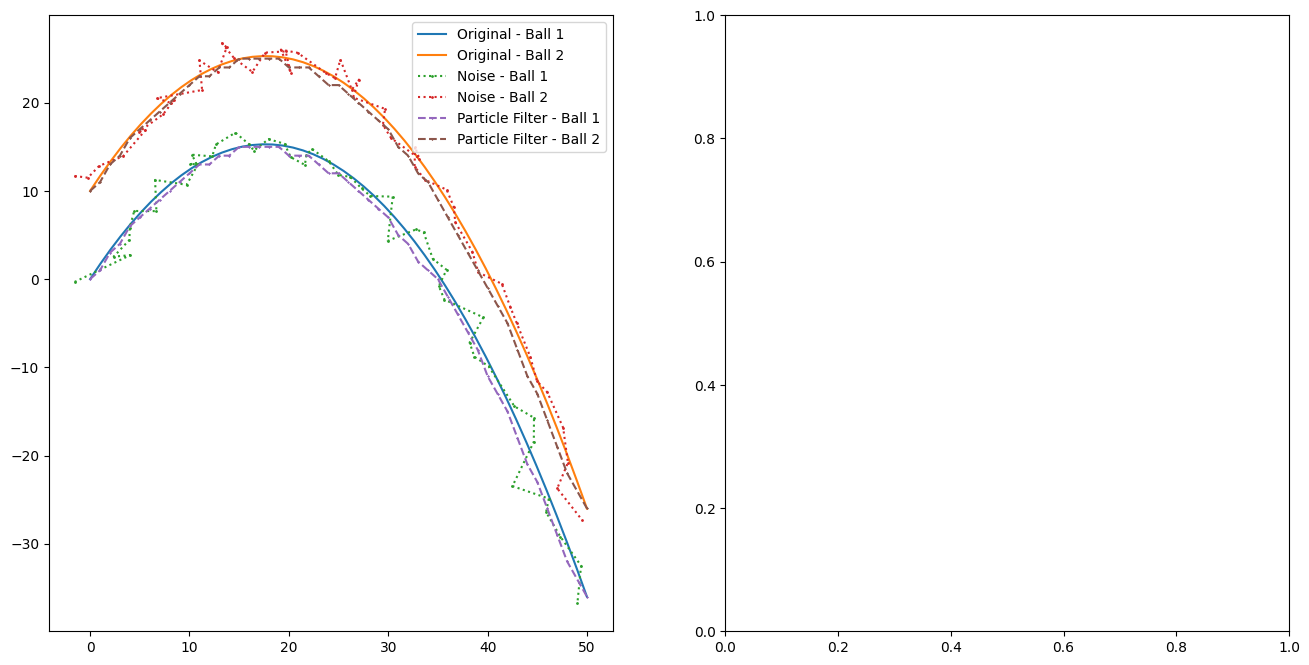

In [56]:
# plotting
# TODO: What is
x_estimated_1 = estimated_states[:, 0, 0, 0]
y_estimated_1 = estimated_states[:, 0, 0, 1]
x_estimated_2 = estimated_states[:, 1, 0, 0]
y_estimated_2 = estimated_states[:, 1, 0, 1]

fig, (ax,ax1) = plt.subplots(1,2,figsize = (16,8))
ax.plot(signal[0][0],signal[0][1],ls = '-',markersize = 1,label = 'Original - Ball 1')
ax.plot(signal[1][0],signal[1][1],ls = '-',markersize = 1,label = 'Original - Ball 2')

ax.plot(signal_n[0][0],signal_n[0][1],'o',ls=':',markersize = 1,label = 'Noise - Ball 1')
ax.plot(signal_n[1][0],signal_n[1][1],'o',ls=':',markersize = 1,label = 'Noise - Ball 2')

# Don't have drop out yet
#ax.plot(signal_m[0],signal_m[1],'x',markersize = 4)
#ax.plot(signal_m[0],signal_m[1],'x',markersize = 4)

ax.plot(x_estimated_1,y_estimated_1,'x',ls = '--',markersize = 1,label = 'Particle Filter - Ball 1')
ax.plot(x_estimated_2,y_estimated_2,'x',ls = '--',markersize = 1,label = 'Particle Filter - Ball 2')

ax.legend(loc = 'upper right')

"""
min_y = min(signal_n[1])
min_x = min(signal_n[0])
max_y = max(signal_n[1])
max_x = max(signal_n[0])
print(min_y,max_y)
print(min_x,max_x)
ax.set(ylim=(min_y-min_y*0.1,max_y+0.1*max_y),xlim=(min_x-min_x*0.1,max_x+0.1*max_x))
"""
"""
ax1.plot(time,signal_c[2],'o',ls = '-',markersize = 4)
ax1.plot(time,signal_c[3],'o',ls = '-',markersize = 4)
"""